# Setup

In [1]:
import os
from minio import Minio

MINIO_ENDPOINT = os.environ.get("MINIO_ENDPOINT", "host.docker.internal:9000")
MINIO_ACCESS_KEY = os.environ.get("MINIO_ACCESS_KEY", "minioadmin")
MINIO_SECRET_KEY = os.environ.get("MINIO_SECRET_KEY", "minioadmin")
MINIO_SECURE = os.environ.get("MINIO_SECURE", "False").lower() == "true"

minio_client = None
try:
    minio_client = Minio(
        MINIO_ENDPOINT,
        access_key=MINIO_ACCESS_KEY,
        secret_key=MINIO_SECRET_KEY,
        secure=MINIO_SECURE
    )
    print(f"MinIO client initialized for endpoint: {MINIO_ENDPOINT}")
except Exception as e:
    print(f"Fatal Error: Could not initialize MinIO client: {e}")

MinIO client initialized for endpoint: host.docker.internal:9000


In [2]:
from pymilvus import MilvusClient

base_url = "host.docker.internal"
URI = f"http://{base_url}:19530"
try:
    milvus_client = MilvusClient(
        uri=URI,
    )
    print(f"Milvus client initialized for endpoint: {URI}")
except Exception as e:
    print(f"Fatal Error: Could not initialize Milvus client: {e}")

Milvus client initialized for endpoint: http://host.docker.internal:19530


In [3]:
import getpass
import os

from dotenv import load_dotenv
load_dotenv()

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import OpenAIEmbeddings
from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# Milvus database operations

In [4]:
def db_create(db_name: str):
    if db_name not in milvus_client.list_databases():
        try:
            milvus_client.create_database(db_name=db_name)
        except Exception as e:
            print(e.message)
            return False
    return True

# Milvus collection operations

In [5]:
def collection_create(collection_name: str, dimension: int):
    if collection_name in milvus_client.list_collections():
        print("collection already exists.")
        return collection_name
        
    milvus_client.create_collection(
        collection_name=collection_name,
        dimension=dimension
    )

    return collection_name

def collection_create_drop_on_existence(collection_name: str, dimension: int):
    if collection_name in milvus_client.list_collections():
        print("collection already exists. It will be dropped.")
        collection_delete(collection_name)
        
    milvus_client.create_collection(
        collection_name=collection_name,
        dimension=dimension
    )

    return collection_name


def collection_delete(collection_name: str):
    milvus_client.drop_collection(collection_name)
    if collection_name not in milvus_client.list_collections():
        return True
    return False

def collection_list():
    return milvus_client.list_collections()

def collection_retrieve(collection_name: str):
    return milvus_client.describe_collection(collection_name)

def collection_rename(old_name, new_name):
    milvus_client.rename_collection(old_name, new_name)

# Minio file operations

In [6]:
import uuid
import time
import base64
import string
import random
import mimetypes
from minio.error import S3Error

def generate_file_id(prefix="file-"):
    random_uuid = uuid.uuid4().hex[:16]
    random_str = ''.join(random.choices(string.ascii_letters + string.digits, k=6))

    return f"{prefix}{random_uuid}{random_str}"

def create_bucket(bucket_name: str):
    try:
        if not minio_client.bucket_exists(bucket_name):
            print(f"Attempting to create bucket '{bucket_name}'...")
            minio_client.make_bucket(bucket_name)
            print(f"Bucket '{bucket_name}' created.")
        return True
    
    except S3Error as e:
        print(f"Error checking or creating bucket '{bucket_name}': {e}")
        return False
    

def file_upload_minio(file_path: str, bucket_name: str, purpose: str = "assistants"):
    """
    Uploads a file (from local path or URL) to MinIO and stores metadata.

    Args:
        file_path (str): The local path to the file.
        bucket_name (str): The MinIO bucket to upload the file to.
        purpose (str): The purpose of the file (e.g., "assistants", "dataset").

    Returns:
        str: The generated file_id if the upload is successful, None otherwise.
    """
    if not minio_client:
        print("Error: MinIO client is not initialized. Cannot upload file.")
        return None

    file_id = generate_file_id()
    file_content_stream = None
    resource_to_close = None
    file_size = 0
    content_type = 'application/octet-stream'

    try:
        # print(f"Processing local file: {file_path}")
        if not os.path.exists(file_path):
            print(f"Error: Local file '{file_path}' not found.")
            return None
            
        original_filename = os.path.basename(file_path)
        file_size = os.path.getsize(file_path)
        resource_to_close = open(file_path, "rb")
        file_content_stream = resource_to_close
        
        guessed_type, _ = mimetypes.guess_type(original_filename)
        if guessed_type: content_type = guessed_type
        # print(f"Local file. Filename: '{original_filename}', Size: {file_size} bytes, Type: {content_type}")

        if not file_content_stream:
            print("Error: File content stream could not be established.")
            return None
        
        if file_size == 0:
            print(f"Warning: File '{original_filename}' is 0 bytes.")

        current_timestamp = int(time.time())
        metadata_for_minio = {
            'id': file_id,
            'bytes': str(file_size),
            'created_at': str(current_timestamp),
            'filename': base64.b64encode(original_filename.encode("utf-8")).decode("ascii"),
            'object': 'file',
            'purpose': purpose,
            'status': 'uploaded',
            'expires_at': str(None),
            'status_details': str(None)
        }
        metadata_for_minio = {k: str(v) for k, v in metadata_for_minio.items()}


        minio_object_name = file_id
        create_bucket(bucket_name)
        

        # print(f"Uploading '{original_filename}' as MinIO object '{minio_object_name}' "
        #       f"to bucket '{bucket_name}' (Size: {file_size}, Type: {content_type})...")
        upload_result = minio_client.put_object(
            bucket_name,
            minio_object_name,
            file_content_stream,
            length=file_size,
            metadata=metadata_for_minio,
            content_type=content_type
        )
        # print(f"Successfully uploaded '{minio_object_name}' (ETag: {upload_result.etag}, VersionID: {upload_result.version_id})")
        
        return file_id

    except S3Error as e:
        print(f"MinIO S3 Error: {e}")
        return None
    except FileNotFoundError:
        print(f"Error: Local file '{file_path}' not found.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        import traceback
        traceback.print_exc()
        return None
    finally:
        if resource_to_close:
            try:
                resource_to_close.close()
                # print(f"Closed resource for: {original_filename if original_filename else 'file'}")
            except Exception as e_close:
                print(f"Warning: Error closing resource: {e_close}")


def list_files_minio(bucket_name: str) -> dict:
    """
    Lists files in a MinIO bucket and retrieves their metadata in the specified format.

    Args:
        bucket_name (str): The MinIO bucket to list files from.

    Returns:
        dict: A dictionary with a "data" key containing a list of file information,
              or {"data": []} if errors occur or no files are found.
    """
    if not minio_client:
        print("Error: MinIO client is not initialized. Cannot list files.")
        return {"data": []}

    files_data = []
    try:
        if not minio_client.bucket_exists(bucket_name):
            print(f"Error: Bucket '{bucket_name}' does not exist.")
            return {"data": []}

        # print(f"Listing objects in bucket '{bucket_name}'...")
        objects = minio_client.list_objects(bucket_name, recursive=True)
        
        for obj in objects:
            try:
                object_stat = minio_client.stat_object(bucket_name, obj.object_name)
                
                normalized_stat_meta = {k.lower(): v for k, v in object_stat.metadata.items()}

                def get_value(key_suffix, default=None, is_int=False, is_py_none=False):
                    """Helper to retrieve and convert metadata values."""
                    lookup_key = f"x-amz-meta-{key_suffix.lower()}"
                    value = normalized_stat_meta.get(lookup_key)

                    if value is None:
                        return default

                    if is_py_none and isinstance(value, str) and value.lower() == 'none':
                        return None
                    
                    if is_int:
                        try:
                            return int(value)
                        except (ValueError, TypeError):
                            print(f"Warning: Could not convert metadata '{key_suffix}' ('{value}') for object '{obj.object_name}' to int. Using default: {default}")
                            return default
                    return value

                file_info = {
                    'id': get_value('id', default=obj.object_name),
                    'bytes': object_stat.size, # Authoritative size from object stat
                    'created_at': get_value('created_at', default=0, is_int=True),
                    'filename':  base64.b64decode(get_value('filename', default=obj.object_name)).decode('utf-8'),
                    'object': get_value('object', default='file'),
                    'purpose': get_value('purpose', default='unknown'),
                    'status': get_value('status', default='unknown'), # Retrieves stored status, e.g., 'uploaded'
                    'expires_at': get_value('expires_at', default=None, is_py_none=True),
                    'status_details': get_value('status_details', default=None, is_py_none=True),
                }
                files_data.append(file_info)
                # print(f"  Processed metadata for object: {obj.object_name}")

            except S3Error as stat_err:
                print(f"Error stating object {obj.object_name}: {stat_err}")
            except Exception as e_inner:
                print(f"Unexpected error processing object {obj.object_name}: {e_inner}")
                import traceback
                traceback.print_exc()
        
        # print(f"Found {len(files_data)} objects with metadata in bucket '{bucket_name}'.")

    except S3Error as e:
        print(f"MinIO S3 Error listing files in bucket '{bucket_name}': {e}")
        return {"data": []}
    except Exception as e_outer:
        print(f"An unexpected error occurred while listing files: {e_outer}")
        import traceback
        traceback.print_exc()
        return {"data": []}
        
    return {"data": files_data}


def file_delete_minio(file_id: str, bucket_name: str) -> bool:
    """
    Deletes a file (object) from a MinIO bucket.

    Args:
        bucket_name (str): The MinIO bucket from which to delete the file.
        file_id (str): The ID of the file to delete (this is the MinIO object name).

    Returns:
        bool: True if the file was deleted successfully or did not exist, False otherwise.
    """
    if not minio_client:
        print("Error: MinIO client is not initialized. Cannot delete file.")
        return False

    try:
        if not minio_client.bucket_exists(bucket_name):
            print(f"Error: Bucket '{bucket_name}' does not exist. Cannot delete file '{file_id}'.")
            return False

        # print(f"Attempting to delete file '{file_id}' from bucket '{bucket_name}'...")
        minio_client.remove_object(bucket_name, file_id)
        # print(f"Successfully sent delete request for file '{file_id}' from bucket '{bucket_name}'.")
        return True
        
    except S3Error as e:
        print(f"MinIO S3 Error deleting file '{file_id}' from bucket '{bucket_name}': {e}")
        return False
    except Exception as e:
        print(f"An unexpected error occurred while deleting file '{file_id}': {e}")
        import traceback
        traceback.print_exc()
        return False


def batch_delete_minio(file_ids: list[str], bucket_name: str):
    count = 0
    for file_id in file_ids:
        try:
            file_delete_minio(file_id, bucket_name)
            count += 1
        except Exception as e:
            print("Error occured:", e)

    return f"{count} out of {len(file_ids)} files deleted successfully."
        

def batch_upload_minio(file_paths: list[str], bucket_name: str, purpose: str = "assistants"):
    file_ids = []
    for file_path in file_paths:
        try:
            file_ids.append(file_upload_minio(file_path, bucket_name, purpose))
        except Exception as e:
            print("Err: ", e)

    return file_ids


def delete_bucket_all_files(bucket_name: str):
    list_files = list_files_minio(bucket_name)
    file_ids = [file["id"] for file in list_files["data"]]
    
    return batch_delete_minio(file_ids, bucket_name)

    
def delete_bucket(bucket_name: str):
    """
    Deletes a MinIO bucket.

    Args:
        bucket_name: The name of the bucket to delete.

    Returns:
        True if the bucket was deleted successfully, False otherwise.

    Raises:
        S3Error: If any MinIO-specific error occurs.
        Exception: For any other unexpected errors.
    """
    try:
        if not minio_client.bucket_exists(bucket_name):
            print(f"Error: Bucket '{bucket_name}' does not exist.")
            return False

        minio_client.remove_bucket(bucket_name)
        print(f"Bucket '{bucket_name}' deleted successfully.")
        return True
    except S3Error as e:
        print(f"MinIO S3 Error occurred: {e}")
        if "BucketNotEmpty" in str(e):
            print(f"Hint: Bucket '{bucket_name}' is not empty. Please empty it before deletion.")
        elif "NoSuchBucket" in str(e):
             print(f"Error: Bucket '{bucket_name}' not found during deletion attempt.")
        return False
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return False


def list_buckets():
    """
    Lists all buckets in MinIO.

    Args:
        minio_client: Initialized MinIO client object.

    Returns:
        A list of bucket names, or an empty list if an error occurs or no buckets exist.
    """
    try:
        buckets = minio_client.list_buckets()
        bucket_names = []
        if buckets:
            for bucket in buckets:
                # print(f"  - {bucket.name} (Created: {bucket.creation_date})")
                bucket_names.append(bucket.name)
        return bucket_names
    except S3Error as e:
        print(f"MinIO S3 Error occurred while listing buckets: {e}")
        return []
    except Exception as e:
        print(f"An unexpected error occurred while listing buckets: {e}")
        return []

# Vector store operation

In [7]:
from langchain_milvus import Milvus
from langchain_core.embeddings import Embeddings

def create_vector_store(embeddings: Embeddings, collection_name: str, db_name: str, uri: str, index_params: dict):
    if db_name not in milvus_client.list_databases():
        print("Database does not exists, creating database.")
        milvus_client.create_database(db_name)
        print("database created successfully.")
    try:
        print("Creating vector store...")
        vector_store = Milvus(
            embedding_function=embeddings,
            collection_name=collection_name,
            connection_args={"uri": uri, "db_name": db_name},
            index_params=index_params,
            auto_id=True,
        )
        print("Vector store is created successfully.")
    except Exception as e:
        print("Err: ", e)

    return vector_store

# Vector store file operation

In [8]:
import boto3
from langchain_text_splitters import TextSplitter
from langchain.document_loaders import S3DirectoryLoader, S3FileLoader

def vector_store_file_create_and_pole(file_id: str, bucket_name: str, vector_store: Milvus, text_splitter: TextSplitter):
    s3_loader = S3FileLoader(
        bucket_name,
        file_id,
        endpoint_url=f"http://{MINIO_ENDPOINT}",
        aws_access_key_id=MINIO_ACCESS_KEY,
        aws_secret_access_key=MINIO_SECRET_KEY,
        use_ssl=False
    )
    documents = s3_loader.load()
    
    s3 = boto3.client(
        "s3",        
        endpoint_url=f"http://{MINIO_ENDPOINT}",
        aws_access_key_id=MINIO_ACCESS_KEY,
        aws_secret_access_key=MINIO_SECRET_KEY,
    )
    metadata = s3.head_object(Bucket=bucket_name, Key=file_id).get("Metadata", {})
    filename = base64.b64decode(metadata["filename"]).decode('utf-8')
    
    documents = [
        (doc.metadata.update({"source": filename, "file_id": file_id}) or doc)
        for doc in documents
    ]
    
    all_splits = text_splitter.split_documents(documents)
    _ = vector_store.add_documents(documents=all_splits)
    
    return True


def vector_store_file_delete(file_id: str, vector_store: Milvus):
    try:
        return milvus_client.delete(
            vector_store.collection_name,
            filter=f"file_id == '{file_id}'"
        )
    except:
        return None
    
def vector_store_batch_create_and_pole(file_ids: list[str], bucket_name: str, vector_store: Milvus, text_splitter: TextSplitter):
    s3 = boto3.client(
        "s3",        
        endpoint_url=f"http://{MINIO_ENDPOINT}",
        aws_access_key_id=MINIO_ACCESS_KEY,
        aws_secret_access_key=MINIO_SECRET_KEY,
    )

    docs = []
    for file_id in file_ids:
        s3_loader = S3FileLoader(
            bucket_name,
            file_id,
            endpoint_url=f"http://{MINIO_ENDPOINT}",
            aws_access_key_id=MINIO_ACCESS_KEY,
            aws_secret_access_key=MINIO_SECRET_KEY,
            use_ssl=False
        )
        documents = s3_loader.load()
        
        metadata = s3.head_object(Bucket=bucket_name, Key=file_id).get("Metadata", {})
        filename = base64.b64decode(metadata["filename"]).decode('utf-8')
        
        documents = [
            (doc.metadata.update({"source": filename, "file_id": file_id}) or doc)
            for doc in documents
        ]
        docs.append(*documents)
        
    
    all_splits = text_splitter.split_documents(docs)
    _ = vector_store.add_documents(documents=all_splits)
    
    return True

def vector_store_file_upload_and_pole(file_path: str, vector_store: Milvus):
    pass

def vector_store_file_update(file_id: str, vector_store: Milvus, attributes: dict):
    pass

def vector_store_file_list(vector_store: Milvus):
    pass # not possible at the moment

# usage

#### milvus operation

In [9]:
db_name = "my_db_name"
db_create(db_name)
milvus_client.use_database(db_name)

In [10]:
collection_name = "my_collection"
dimension = 768

collection_create(collection_name, dimension)
collection_create_drop_on_existence(collection_name, dimension)

print(collection_list())
print(collection_retrieve(collection_name))
print(collection_delete(collection_name))
print(collection_list())

collection already exists. It will be dropped.
['my_collection']
{'collection_name': 'my_collection', 'auto_id': False, 'num_shards': 1, 'description': '', 'fields': [{'field_id': 100, 'name': 'id', 'description': '', 'type': <DataType.INT64: 5>, 'params': {}, 'is_primary': True}, {'field_id': 101, 'name': 'vector', 'description': '', 'type': <DataType.FLOAT_VECTOR: 101>, 'params': {'dim': 768}}], 'functions': [], 'aliases': [], 'collection_id': 459926531313445103, 'consistency_level': 2, 'properties': {}, 'num_partitions': 1, 'enable_dynamic_field': True, 'created_timestamp': 459926894250295307, 'update_timestamp': 459926894250295307}
True
[]


#### minio operation

In [11]:
from glob import glob
file_paths = glob("./sample_data/salamat/*")
file_path = file_paths[0]
file_paths

['./sample_data/salamat/سرپایی.docx',
 './sample_data/salamat/نظارت.docx',
 './sample_data/salamat/بیمه گری.docx',
 './sample_data/salamat/دارویی.docx',
 './sample_data/salamat/صعب العلاج.docx',
 './sample_data/salamat/نظام ارجاع و پزشک خانواده.docx',
 './sample_data/salamat/خسارت متفرقه.docx',
 './sample_data/salamat/نسخه الکترونیک.docx',
 './sample_data/salamat/بستری.docx']

In [12]:
bucket_name = "test-bucket"

In [13]:
file_upload_minio(file_path, bucket_name)

'file-74f4bb5a070d4385lltssh'

In [14]:
list_files_minio(bucket_name)

{'data': [{'id': 'file-05bdf51b0ed74520k6KMUZ',
   'bytes': 40332,
   'created_at': 1754472508,
   'filename': 'دارویی.docx',
   'object': 'file',
   'purpose': 'assistants',
   'status': 'uploaded',
   'expires_at': None,
   'status_details': None},
  {'id': 'file-3c1312494ec141c8GVDRiG',
   'bytes': 38578,
   'created_at': 1754472508,
   'filename': 'بستری.docx',
   'object': 'file',
   'purpose': 'assistants',
   'status': 'uploaded',
   'expires_at': None,
   'status_details': None},
  {'id': 'file-74f4bb5a070d4385lltssh',
   'bytes': 43000,
   'created_at': 1754481869,
   'filename': 'سرپایی.docx',
   'object': 'file',
   'purpose': 'assistants',
   'status': 'uploaded',
   'expires_at': None,
   'status_details': None},
  {'id': 'file-7655e3adaa3946d8sy6fyz',
   'bytes': 45297,
   'created_at': 1754472508,
   'filename': 'بیمه گری.docx',
   'object': 'file',
   'purpose': 'assistants',
   'status': 'uploaded',
   'expires_at': None,
   'status_details': None},
  {'id': 'file-84b0

In [15]:
file_ids = batch_upload_minio(file_paths, bucket_name)
file_ids

['file-6aa9af4a53e24040nGlNm7',
 'file-fbd7a0af6e894144uIxtyt',
 'file-dab2d8174f5449e073YR1q',
 'file-eee40ee6225144dbIPvEMt',
 'file-bd622182c9f847b4KrPvFb',
 'file-965b79dbf78f41efC8oH1p',
 'file-0be611e86b4d42027pSjzL',
 'file-4c4e5e223a8b42e0VdSGpQ',
 'file-a06d76f7a5fe4c59765bYJ']

In [16]:
list_files_minio(bucket_name)

{'data': [{'id': 'file-05bdf51b0ed74520k6KMUZ',
   'bytes': 40332,
   'created_at': 1754472508,
   'filename': 'دارویی.docx',
   'object': 'file',
   'purpose': 'assistants',
   'status': 'uploaded',
   'expires_at': None,
   'status_details': None},
  {'id': 'file-0be611e86b4d42027pSjzL',
   'bytes': 39202,
   'created_at': 1754481870,
   'filename': 'خسارت متفرقه.docx',
   'object': 'file',
   'purpose': 'assistants',
   'status': 'uploaded',
   'expires_at': None,
   'status_details': None},
  {'id': 'file-3c1312494ec141c8GVDRiG',
   'bytes': 38578,
   'created_at': 1754472508,
   'filename': 'بستری.docx',
   'object': 'file',
   'purpose': 'assistants',
   'status': 'uploaded',
   'expires_at': None,
   'status_details': None},
  {'id': 'file-4c4e5e223a8b42e0VdSGpQ',
   'bytes': 40068,
   'created_at': 1754481870,
   'filename': 'نسخه الکترونیک.docx',
   'object': 'file',
   'purpose': 'assistants',
   'status': 'uploaded',
   'expires_at': None,
   'status_details': None},
  {'id'

In [17]:
file_delete_minio(file_ids[0], bucket_name)

True

In [18]:
batch_delete_minio(file_ids, bucket_name)

'9 out of 9 files deleted successfully.'

In [19]:
delete_bucket_all_files(bucket_name)

'10 out of 10 files deleted successfully.'

In [20]:
delete_bucket(bucket_name)

Bucket 'test-bucket' deleted successfully.


True

In [21]:
list_buckets()

[]

#### vector store operation

In [22]:
from glob import glob
file_paths = glob("./sample_data/salamat/*")
file_path = file_paths[0]

In [23]:
bucket_name = "test-bucket"
db_name = "test_db"
collection_name = "test_collection"

In [24]:
vector_store = create_vector_store(
    embeddings=embeddings,
    collection_name=collection_name,
    db_name=db_name,
    uri=URI,
    index_params={"index_type": "FLAT", "metric_type": "L2"},
)

Creating vector store...
Vector store is created successfully.


In [25]:
file_ids = batch_upload_minio(file_paths, bucket_name)

Attempting to create bucket 'test-bucket'...
Bucket 'test-bucket' created.


In [26]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)

In [27]:
vector_store_file_create_and_pole(file_ids[0], bucket_name, vector_store, text_splitter)

True

In [ ]:
vector_store_batch_create_and_pole(file_ids, bucket_name, vector_store, text_splitter)

In [28]:
vector_store.similarity_search()

# Generation

In [24]:
from langchain_core.tools import tool

@tool
def retrieve(input_query: str):
    """
    Accesses an external knowledge base to retrieve relevant and useful documents based on the user's query.
    Use this function whenever the query requires detailed factual information, specific reference material,
    or external background context that might not be part of my general training data.
    This function is particularly useful for questions seeking explanations, definitions, or examples
    that benefit from a comprehensive document search.
    """
    retrieved_docs = vector_store.similarity_search(input_query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized


tools = [retrieve]

In [25]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage


def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}


def generate(state: MessagesState):
    """Generate answer."""
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, please state that you don't know "
        "in the same language as the question. "
        "Use three sentences maximum and keep the answer concise."
        "\n\n"
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    response = llm.invoke(prompt)
    return {"messages": [response]}

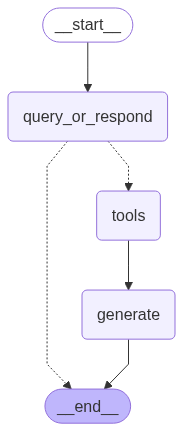

In [26]:
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(MessagesState)
graph_builder.add_node(query_or_respond)

graph_builder.add_node(ToolNode(tools))
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()
graph

In [137]:
%time
print()

CPU times: user 13 μs, sys: 2 μs, total: 15 μs
Wall time: 35.5 μs



In [142]:
%%time
generate_with_file_search(
    query="What is deep research by OpenAI?", 
    vector_store_id=vector_store_id,
)

CPU times: user 30.1 ms, sys: 1.01 ms, total: 31.1 ms
Wall time: 9.71 s


Response(id='resp_682abf436ff08191a4b2e55170bb297d03d79a5751f7dba7', created_at=1747631939.0, error=None, incomplete_details=None, instructions=None, metadata={}, model='gpt-4o-mini-2024-07-18', object='response', output=[ResponseFileSearchToolCall(id='fs_682abf43d4648191afda528fcd6ce38903d79a5751f7dba7', queries=['deep research by OpenAI', 'What is deep research by OpenAI?'], status='completed', type='file_search_call', results=None), ResponseOutputMessage(id='msg_682abf46216481919adbee6bce692e9303d79a5751f7dba7', content=[ResponseOutputText(annotations=[AnnotationFileCitation(file_id='file-HYRTF6hP2UwEci3hHzUSzf', index=528, type='file_citation', filename='deep_research_blog.pdf'), AnnotationFileCitation(file_id='file-HYRTF6hP2UwEci3hHzUSzf', index=769, type='file_citation', filename='deep_research_blog.pdf'), AnnotationFileCitation(file_id='file-HYRTF6hP2UwEci3hHzUSzf', index=952, type='file_citation', filename='deep_research_blog.pdf'), AnnotationFileCitation(file_id='file-HYRTF6hP

In [136]:
generate_with_file_search(
    query="what do you know about task decomposition?", 
    vector_store_id=vector_store_id,
)


KeyboardInterrupt



In [146]:
%%time
generate_with_information_retrieval(
    query="What is deep research by OpenAI?", 
    vector_store_id=vector_store_id,
)

<sources><result file_id='file-HYRTF6hP2UwEci3hHzUSzf' file_name='deep_research_blog.pdf'><content>Introducing deep research | OpenAI


February 2, 2025 Release

Introducing deep research
An agent that uses reasoning to synthesize large amounts of
online information and complete multi-step research tasks
for you. Available to Pro users today, Plus and Team next.

Try on ChatGPT

Listen to article 8:18 Share

21/02/2025, 19:58 Introducing deep research | OpenAI

https://openai.com/index/introducing-deep-research/ 1/38

https://openai.com/research/index/release/
https://chatgpt.com/
https://openai.com/


Today we’re launching deep research in ChatGPT, a new agentic capability that
conducts multi-step research on the internet for complex tasks. It accomplishes in
tens of minutes what would take a human many hours.

Deep research is OpenAI's next agent that can do work for you independently—you
give it a prompt, and ChatGPT will find, analyze, and synthesize hundreds of online
sources to c

ChatCompletion(id='chatcmpl-BYnD6ka5TzpGaBM6QsWtZRFnGWy1N', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="Deep research is a new capability introduced by OpenAI that allows an agent in ChatGPT to conduct multi-step research tasks by synthesizing large amounts of online information. It operates independently to find, analyze, and synthesize data from hundreds of sources, creating comprehensive reports similar to those produced by a research analyst. This feature is designed for intensive knowledge work in fields like finance, science, policy, and engineering, as well as for personalized shopping recommendations. It leverages a version of OpenAI's o3 model optimized for web browsing and data analysis, and is particularly effective at finding niche information. Users can request specific reports and receive a detailed output supported by citations and summaries of the research process. Deep research is available to Pro users and will 

In [134]:
generate_with_information_retrieval(
    query="what do you know about task decomposition?", 
    vector_store_id=vector_store_id,
)

ChatCompletion(id='chatcmpl-BYVlITUJnEKp7rC2GxYljKiHM4E2l', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="I don't know.", refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))], created=1747564944, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier='default', system_fingerprint='fp_dbaca60df0', usage=CompletionUsage(completion_tokens=4, prompt_tokens=7772, total_tokens=7776, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))

In [112]:
# rag_client = RAG_Client()
# rag_client.file_search("What is deep research by OpenAI?")

# real example

In [ ]:
bucket_name = "salamat"
db_name = "salamat"
collection_name = "salamat_collection"

In [ ]:
vector_store = create_vector_store(
    embeddings=embeddings,
    collection_name=collection_name,
    db_name=db_name,
    uri=URI,
    index_params={"index_type": "FLAT", "metric_type": "L2"},
)

Creating vector store...
Vector store is created successfully.


In [14]:
from glob import glob
file_paths = glob("./sample_data/salamat/*")
file_paths

['./sample_data/salamat/سرپایی.docx',
 './sample_data/salamat/نظارت.docx',
 './sample_data/salamat/بیمه گری.docx',
 './sample_data/salamat/دارویی.docx',
 './sample_data/salamat/صعب العلاج.docx',
 './sample_data/salamat/نظام ارجاع و پزشک خانواده.docx',
 './sample_data/salamat/خسارت متفرقه.docx',
 './sample_data/salamat/نسخه الکترونیک.docx',
 './sample_data/salamat/بستری.docx']

In [19]:
file_ids = batch_upload_minio(file_paths, bucket_name)
file_ids

Attempting to create bucket 'salamat'...
Bucket 'salamat' created.


['file-77d15362574d47a9bSBOiJ',
 'file-a23af1e9a65d4eb5fffPDD',
 'file-373a8cbdbdc84130eSUsrb',
 'file-a4cc61aaca454e35UNISD1',
 'file-73cd60c513104284VJs0gP',
 'file-93313ea024514a712hvPBo',
 'file-c3d65da1910f40f263JS2e',
 'file-bbdc05f63a3b4835LUNsdi',
 'file-2b5bedef32854565xGNPJq']

In [23]:
from langchain_text_splitters import RecursiveCharacterTextSplitter, TextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

vector_store_batch_create_and_pole(file_ids, bucket_name, vector_store, text_splitter)

True

In [28]:
input_message = "هتلینگ"
for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

هتلینگ
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_EqfFKhnr89qlE0AHC50KaG0Y)
 Call ID: call_EqfFKhnr89qlE0AHC50KaG0Y
  Args:
    input_query: هتلینگ
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'بستری.docx', 'file_id': 'file-2b5bedef32854565xGNPJq', 'pk': 458266833003757106}
Content: پرسش:

هزینه اقامت (هتلینگ) اعلام شده در خصوص خدمات بستری به ازای هر شب بستری شدن بیمه شده می باشد یا برای کل دوران بستری محاسبه می شود؟

پاسخ:

 هزینه هتلینگ  بر اساس مصوبات سالیانه اعلامی هیأت محترم وزیران، به ازای هر شب بستری مشروط به اقامت بیش از 6 ساعت  و بر اساس درجه اعتباربخشی بیمارستان محاسبه می‌گردد.

پرسش:

با توجه جدول هزینه اقامت (هتلینگ) در خصوص هزینه همراه آیا برای این ردیف سهم سازمان نیز لحاظ می گردد یا اینکه هزینه همراه باید بصورت کامل توسط بیمه شده پرداخت گردد؟

پاسخ:

هزینه